In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7223 files belonging to 5 classes.


In [4]:
class_name = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
def get_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_partition(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
data_scale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])

In [9]:
data_augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
import os
import tensorflow as tf

# Path to the directory where models are saved
model_dir = "../plant_models"

# List of model versions (folders or files) in the directory
model_versions = [i for i in os.listdir(model_dir) if i.isdigit()]

# Get the latest model version
if model_versions:
    latest_version = max([int(i) for i in model_versions])
    model_path = os.path.join(model_dir, str(latest_version))
else:
    raise ValueError("No models found in the directory.")

# Load the model
model = tf.keras.models.load_model(f"../plant_models/{latest_version}")

print(f"Loaded model from version {latest_version}")

Loaded model from version 4


In [12]:
history = model.fit(train_ds, epochs = 70, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/70
180/180 [==============================] - 63s 279ms/step - loss: 1.3367 - accuracy: 0.6376 - val_loss: 0.6116 - val_accuracy: 0.7756
Epoch 2/70
180/180 [==============================] - 43s 236ms/step - loss: 0.4449 - accuracy: 0.8426 - val_loss: 0.3916 - val_accuracy: 0.8509
Epoch 3/70
180/180 [==============================] - 43s 240ms/step - loss: 0.3028 - accuracy: 0.8913 - val_loss: 0.3275 - val_accuracy: 0.8892
Epoch 4/70
180/180 [==============================] - 43s 241ms/step - loss: 0.2476 - accuracy: 0.9096 - val_loss: 0.3166 - val_accuracy: 0.8920
Epoch 5/70
180/180 [==============================] - 44s 243ms/step - loss: 0.2182 - accuracy: 0.9231 - val_loss: 0.2774 - val_accuracy: 0.8977
Epoch 6/70
180/180 [==============================] - 44s 243ms/step - loss: 0.1871 - accuracy: 0.9304 - val_loss: 0.2547 - val_accuracy: 0.9020
Epoch 7/70
180/180 [==============================] - 44s 243ms/step - loss: 0.1544 - accuracy: 0.9414 - val_loss: 0.1712 - val_ac

In [17]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    predicted_class = class_name[np.argmax(predictions[0])]
    conf = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, conf

1/1 [==============================] - 0s 24ms/step


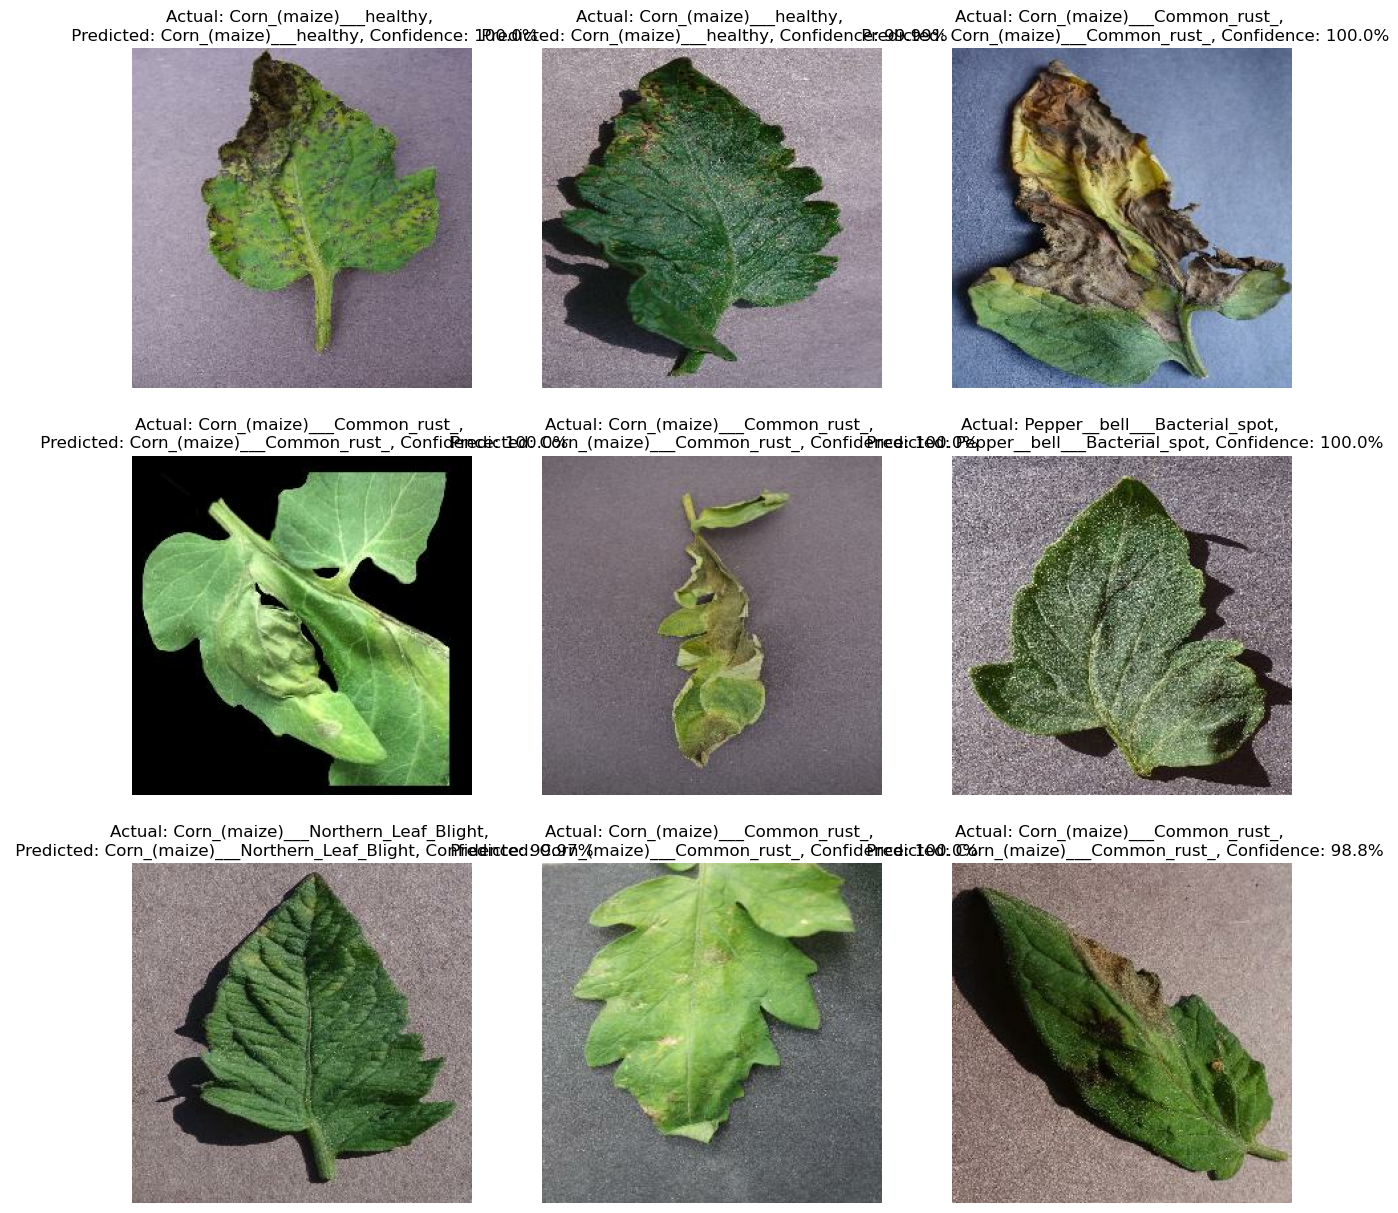

In [18]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted, conf = predict(model, images[i].numpy())
        act = class_name[labels[i]]

        plt.title(f'Actual: {act}, \n Predicted: {predicted}, Confidence: {conf}%')
        
        plt.axis("off")

In [19]:
import os

if not os.path.exists("../plant_models"):
    os.makedirs("../plant_models")

model_versions = [i for i in os.listdir("../plant_models") if i.isdigit()]

model_version = max([int(i) for i in model_versions] + [0]) + 1

model.save(f"../plant_models/{model_version}")

INFO:tensorflow:Assets written to: ../plant_models/5\assets


INFO:tensorflow:Assets written to: ../plant_models/5\assets
